# Robust Linear Models

In [1]:
%matplotlib inline

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import statsmodels.api as sm

## Estimation

Load data:

In [3]:
data = sm.datasets.stackloss.load()
data.exog = sm.add_constant(data.exog)

Huber's T norm with the (default) median absolute deviation scaling

In [4]:
huber_t = sm.RLM(data.endog, data.exog, M=sm.robust.norms.HuberT())
hub_results = huber_t.fit()
print(hub_results.params)
print(hub_results.bse)
print(
    hub_results.summary(
        yname="y", xname=["var_%d" % i for i in range(len(hub_results.params))]
    )
)

const       -41.026498
AIRFLOW       0.829384
WATERTEMP     0.926066
ACIDCONC     -0.127847
dtype: float64
const        9.791899
AIRFLOW      0.111005
WATERTEMP    0.302930
ACIDCONC     0.128650
dtype: float64
                    Robust linear Model Regression Results                    
Dep. Variable:                      y   No. Observations:                   21
Model:                            RLM   Df Residuals:                       17
Method:                          IRLS   Df Model:                            3
Norm:                          HuberT                                         
Scale Est.:                       mad                                         
Cov Type:                          H1                                         
Date:                Fri, 26 Sep 2025                                         
Time:                        12:05:30                                         
No. Iterations:                    19                                         


Huber's T norm with 'H2' covariance matrix

In [5]:
hub_results2 = huber_t.fit(cov="H2")
print(hub_results2.params)
print(hub_results2.bse)

const       -41.026498
AIRFLOW       0.829384
WATERTEMP     0.926066
ACIDCONC     -0.127847
dtype: float64
const        9.089504
AIRFLOW      0.119460
WATERTEMP    0.322355
ACIDCONC     0.117963
dtype: float64


Andrew's Wave norm with Huber's Proposal 2 scaling and 'H3' covariance matrix

In [6]:
andrew_mod = sm.RLM(data.endog, data.exog, M=sm.robust.norms.AndrewWave())
andrew_results = andrew_mod.fit(scale_est=sm.robust.scale.HuberScale(), cov="H3")
print("Parameters: ", andrew_results.params)

Parameters:  const       -40.881796
AIRFLOW       0.792761
WATERTEMP     1.048576
ACIDCONC     -0.133609
dtype: float64


See ``help(sm.RLM.fit)`` for more options and ``module sm.robust.scale`` for scale options

## Comparing OLS and RLM

Artificial data with outliers:

In [7]:
nsample = 50
x1 = np.linspace(0, 20, nsample)
X = np.column_stack((x1, (x1 - 5) ** 2))
X = sm.add_constant(X)
sig = 0.3  # smaller error variance makes OLS<->RLM contrast bigger
beta = [5, 0.5, -0.0]
y_true2 = np.dot(X, beta)
y2 = y_true2 + sig * 1.0 * np.random.normal(size=nsample)
y2[[39, 41, 43, 45, 48]] -= 5  # add some outliers (10% of nsample)

### Example 1: quadratic function with linear truth

Note that the quadratic term in OLS regression will capture outlier effects. 

In [8]:
res = sm.OLS(y2, X).fit()
print(res.params)
print(res.bse)
print(res.predict())

[ 4.97961778  0.54309838 -0.01495957]
[0.45148873 0.06970377 0.00616771]
[ 4.60562864  4.88586868  5.16112427  5.43139542  5.69668212  5.95698438
  6.21230219  6.46263556  6.70798449  6.94834896  7.183729    7.41412459
  7.63953573  7.85996243  8.07540468  8.28586249  8.49133585  8.69182477
  8.88732924  9.07784927  9.26338486  9.443936    9.61950269  9.79008494
  9.95568274 10.1162961  10.27192501 10.42256948 10.56822951 10.70890509
 10.84459622 10.97530291 11.10102515 11.22176295 11.33751631 11.44828522
 11.55406968 11.6548697  11.75068527 11.8415164  11.92736309 12.00822533
 12.08410312 12.15499647 12.22090538 12.28182984 12.33776985 12.38872542
 12.43469654 12.47568322]


Estimate RLM:

In [9]:
resrlm = sm.RLM(y2, X).fit()
print(resrlm.params)
print(resrlm.bse)

[ 4.90388844e+00  5.27529308e-01 -4.37817960e-03]
[0.11990159 0.01851119 0.00163795]


Draw a plot to compare OLS estimates to the robust estimates:

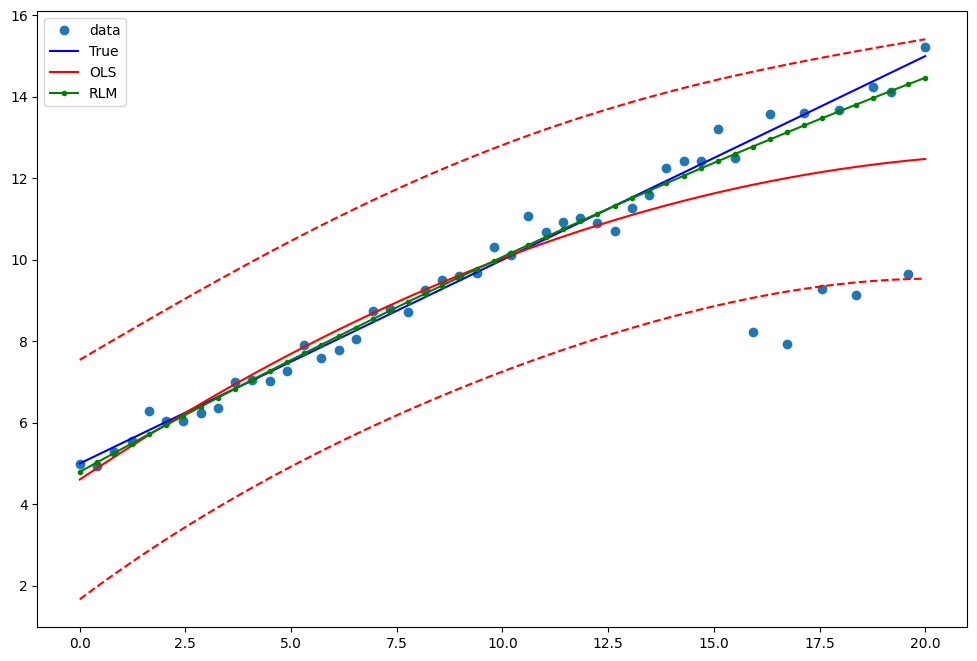

In [10]:
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111)
ax.plot(x1, y2, "o", label="data")
ax.plot(x1, y_true2, "b-", label="True")
pred_ols = res.get_prediction()
iv_l = pred_ols.summary_frame()["obs_ci_lower"]
iv_u = pred_ols.summary_frame()["obs_ci_upper"]

ax.plot(x1, res.fittedvalues, "r-", label="OLS")
ax.plot(x1, iv_u, "r--")
ax.plot(x1, iv_l, "r--")
ax.plot(x1, resrlm.fittedvalues, "g.-", label="RLM")
ax.legend(loc="best")

### Example 2: linear function with linear truth

Fit a new OLS model using only the linear term and the constant:

In [11]:
X2 = X[:, [0, 1]]
res2 = sm.OLS(y2, X2).fit()
print(res2.params)
print(res2.bse)

[5.58257985 0.39350273]
[0.39558992 0.03408563]


Estimate RLM:

In [12]:
resrlm2 = sm.RLM(y2, X2).fit()
print(resrlm2.params)
print(resrlm2.bse)

[5.05336695 0.48867362]
[0.10321337 0.00889328]


Draw a plot to compare OLS estimates to the robust estimates:

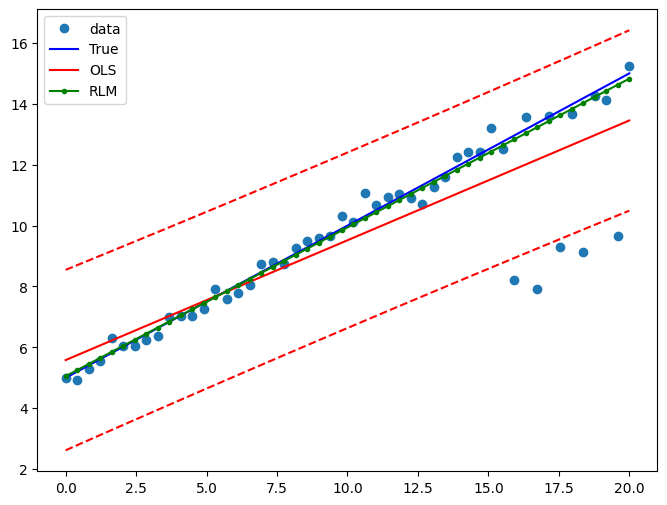

In [13]:
pred_ols = res2.get_prediction()
iv_l = pred_ols.summary_frame()["obs_ci_lower"]
iv_u = pred_ols.summary_frame()["obs_ci_upper"]

fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(x1, y2, "o", label="data")
ax.plot(x1, y_true2, "b-", label="True")
ax.plot(x1, res2.fittedvalues, "r-", label="OLS")
ax.plot(x1, iv_u, "r--")
ax.plot(x1, iv_l, "r--")
ax.plot(x1, resrlm2.fittedvalues, "g.-", label="RLM")
legend = ax.legend(loc="best")